IMPORTING NECESSARY LIBRARIES

In [ ]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms,datasets
from PIL import Image
import timeit
from skimage import io, transform
import os
from torch.utils.data import Dataset
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The sample pictures have been moved to a single folder named "images" and excel sheet containing labels is kept seperate.

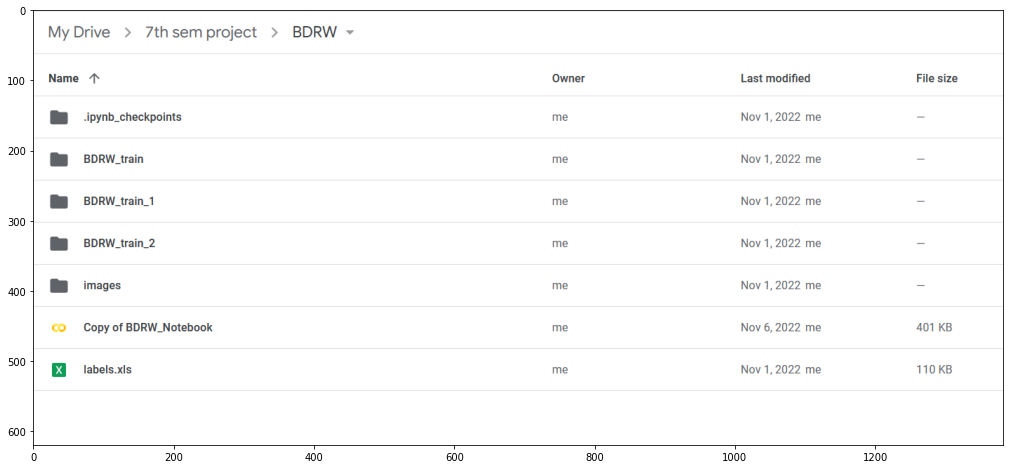

In [ ]:
plt.figure(figsize = (150, 8))
plt.imshow(io.imread(os.path.join('/content/drive/MyDrive/7th sem project/BDRW/folder.png')))
plt.show()

In [ ]:
pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 3.3 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/7th sem project/BDRW/labels.xls",header = None)
df.head()

all_labels = pd.unique(df[1])
label_count = df[1].value_counts()

test_proportion = 393/1393

img_name = df[0]
digit_value = df[1]

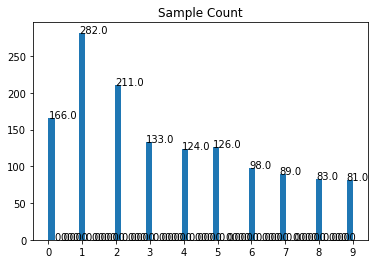

In [ ]:
arr=plt.hist(df[1],bins=50)
for i in range(50):
    plt.text(arr[1][i],arr[0][i],str(arr[0][i]))
plt.xticks(np.arange(10))
plt.title("Sample Count")
plt.show()

From the above data it can be clearly observed that class imbalance exists for our data, hence proportionate selection is used for test data to maintain ratio of all classes in train and test datasets

In [ ]:
temp = int(label_count[9]*test_proportion)
test_df = df[df[1]==9].sample(temp)
for i in range(len(all_labels-1)):
    temp = int(label_count[i]*test_proportion)
    test_df = test_df.append(df[df[1]==i].sample(temp))
test_df = test_df.iloc[:393]
test_df = test_df.sample(frac = 1)

In [ ]:
train_df = df
for i in test_df.index:
    if(i in train_df.index):
        train_df.drop(i,inplace=True,axis=0)
train_df = train_df.iloc[:1000]
train_df = train_df.sample(frac = 1)

train_df.reset_index(drop=True,inplace = True)
test_df.reset_index(drop=True,inplace = True)

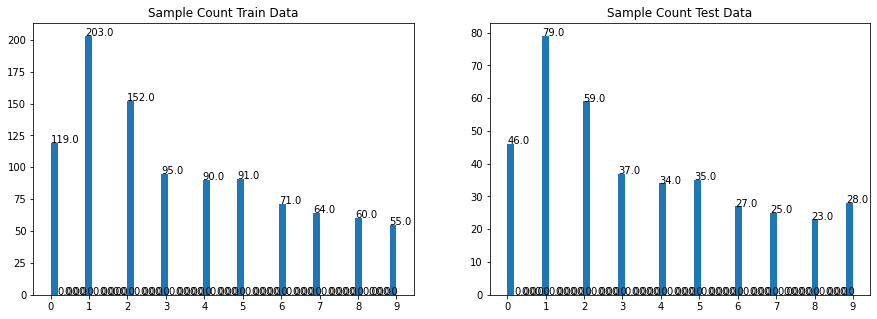

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
arr1=plt.hist(train_df[1],bins=50)
for i in range(50):
    plt.text(arr1[1][i],arr1[0][i],str(arr1[0][i]))
plt.xticks(np.arange(10))
plt.title("Sample Count Train Data")
plt.subplot(122)
arr2=plt.hist(test_df[1],bins=50)
for i in range(50):
    plt.text(arr2[1][i],arr2[0][i],str(arr2[0][i]))
plt.xticks(np.arange(10))
plt.title("Sample Count Test Data")
plt.show()

Function to display sample images

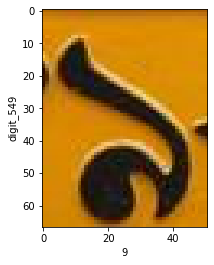

In [ ]:
def show_img(image_name,image, digit):
    
    plt.ylabel(image_name)
    plt.xlabel(digit)
    plt.imshow(image)

plt.figure()
sample_number = 500
show_img(img_name[sample_number],io.imread(os.path.join('/content/drive/MyDrive/7th sem project/BDRW/images/', img_name[sample_number]+'.jpg')),
               digit_value[sample_number])
plt.show()

Here, I defined a function for creating dataset with tensors formed from images and labels combining the images and excel sheet containing labels

In [ ]:
class bdrw_dataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.digits_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.digits_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.digits_frame.iloc[idx, 0]+'.jpg')
        image = io.imread(img_name)
        image = Image.fromarray(np.uint8((image)*255))
    
        
        digits = self.digits_frame.iloc[idx, 1]
        digits = np.array([digits])
        if self.transform:
            image = self.transform(image)

        return image,digits

Creating the Training and Test Datasets from the help of above defined function

In [ ]:
batch_size = 32
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = bdrw_dataset(train_df,'/content/drive/MyDrive/7th sem project/BDRW/images',transform = transform)
test_set = bdrw_dataset(test_df,'/content/drive/MyDrive/7th sem project/BDRW/images',transform = transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
use_gpu = torch.cuda.is_available()

if use_gpu:
    print('GPU is avaialble!')
    
else :
    print("Not Available")

GPU is avaialble!


Defining the model

In [ ]:
dropout_prob = 0.4

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv1_drop = nn.Dropout2d(p=dropout_prob)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=dropout_prob)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)        
        self.fc1 = nn.Linear(400, 120)
        self.fc1_drop = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(120, 84)
        self.fc1_drop = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)
net = LeNet()
net = net.cuda()
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_drop): Dropout2d(p=0.4, inplace=False)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.4, inplace=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Few dropout layers are introduced in between the model to avoid overfitting

In [ ]:
!pip install pytorch_model_summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytorch_model_summary import summary

# show input shape
print(summary(LeNet(), torch.zeros((3, 3, 32, 32)), show_input=True))

# show output shape and hierarchical view of net
print(summary(LeNet(), torch.zeros((3, 3, 32, 32)), show_input=False, show_hierarchical=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [3, 3, 32, 32]             456             456
       MaxPool2d-2      [3, 6, 28, 28]               0               0
          Conv2d-3      [3, 6, 14, 14]           2,416           2,416
       MaxPool2d-4     [3, 16, 10, 10]               0               0
          Linear-5            [3, 400]          48,120          48,120
          Linear-6            [3, 120]          10,164          10,164
          Linear-7             [3, 84]             850             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
-----------------------------------------------------------------------
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv2d-1      [3, 6, 28, 28]             456             456
    

Choosing remaining parameters for training the model, also L2 regularization is used in form of weight decay

In [ ]:
from torch import optim

learning_rate=0.005
num_epochs=10
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate,weight_decay=0.025) 

Here 5 fold cross validation has been performed to get better learning of various class features since class imbalance is present in our data and the dataset is not very large, also negative log likelihood loss function is used.

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(5)

fold_count = 0
folds = 5
train_loss = [[]*folds]*num_epochs
train_acc = [[]*folds]*num_epochs
valid_loss = [[]*folds]*num_epochs
valid_acc = [[]*folds]*num_epochs

dataset_sizes = pd.DataFrame({'train':[800],'valid':[200]})

In [ ]:
start = timeit.default_timer()
for train_idx, valid_idx in kf.split(train_df):
        
        
        train_fold_df = train_df.iloc[train_idx].copy()
        valid_fold_df = train_df.iloc[valid_idx].copy()
        
        train_fold_df.reset_index(drop=True,inplace=True)
        valid_fold_df.reset_index(drop=True,inplace=True)
        
        train_fold = bdrw_dataset(train_fold_df,'/content/drive/MyDrive/7th sem project/BDRW/images',transform = transform)
        valid_fold = bdrw_dataset(valid_fold_df,'/content/drive/MyDrive/7th sem project/BDRW/images',transform = transform)

        #dataloaders for training have been created after splitting data for validation during each fold.
        
        trainloader = torch.utils.data.DataLoader(train_fold, batch_size=batch_size, shuffle=True)
        validloader = torch.utils.data.DataLoader(valid_fold, batch_size=batch_size, shuffle=True)

        best_model_wts = net.state_dict()
        best_acc = 0

        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

        
        print('FOLD ',fold_count+1,'\n')
            
        
        for epoch in range(num_epochs):
                    
                    
                        for phase in ['train','valid']:
                            if phase == 'train':
                                net.train(True)
                                dataloader = trainloader
                                
                            
                            else:
                                net.train(False)
                                dataloader = validloader

                            running_loss = 0.0 
                            running_corr = 0
                    
                            
                            for i, data in enumerate(dataloader):
                                inputs,labels = data
                                labels=labels.squeeze()

                                if use_gpu:
                                    inputs = inputs.cuda()
                                    labels = labels.cuda()


                                #Initializing model gradients to zero
                                if phase == 'train':
                                    net.zero_grad()
                                    optimizer.zero_grad() 

                                # Data feed-forward through the network
                                outputs = net(inputs)

                                # Predicted class is the one with maximum probability
                                preds = torch.argmax(outputs,dim=1)

                                # Finding the loss
                                loss = criterion(outputs, labels)

                                if phase=='train':
                                    loss.backward()
                                    optimizer.step()
                                        
                                    
                                # Accumulating the loss for each batch
                                running_loss += loss 
                                # Accumulate number of correct predictions
                                running_corr += torch.sum(preds==labels)    

                            #totalLoss = running_loss/(i+1)
                            # Calculating gradients


                            # Updating the model parameters
                            for f in net.parameters():
                                f.data.sub_(f.grad.data * learning_rate)

                            epoch_loss = running_loss.item()/dataset_sizes[phase]   #Total loss for one epoch
                            epoch_acc = running_corr.item()/dataset_sizes[phase]

                            if phase =='valid' and epoch_acc.item() > best_acc:
                                best_acc = epoch_acc.item()
                                best_model_wts = net.state_dict()

                            if phase == 'train':
                                train_loss[fold_count].append(epoch_loss) #Saving the loss over epochs for plotting the graph
                                train_acc[fold_count].append(epoch_acc) #Saving the accuracy over epochs for plotting the graph
                                print('Epoch {:.0f}/{:.0f} : Training loss: {:.4f} | Training Accuracy: {:.4f} '.format(epoch+1,num_epochs,epoch_loss.item(),epoch_acc.item()))


                            else:
                                valid_loss[fold_count].append(epoch_loss)
                                valid_acc[fold_count].append(epoch_acc)
                                print('Epoch {:.0f}/{:.0f} : Validation loss: {:.4f} | Validation Accuracy: {:.4f}'.format(epoch+1,num_epochs,epoch_loss.item(),epoch_acc.item()))
                        
                        scheduler.step()       
                        
        fold_count = fold_count + 1
        print("\n")

print("\nTotal Training time = ",timeit.default_timer()-start,' seconds')

FOLD  1 

Epoch 1/10 : Training loss: 0.0695 | Training Accuracy: 0.2025 
Epoch 1/10 : Validation loss: 0.0765 | Validation Accuracy: 0.2100
Epoch 2/10 : Training loss: 0.0633 | Training Accuracy: 0.3025 
Epoch 2/10 : Validation loss: 0.0664 | Validation Accuracy: 0.2750
Epoch 3/10 : Training loss: 0.0510 | Training Accuracy: 0.3912 
Epoch 3/10 : Validation loss: 0.0520 | Validation Accuracy: 0.4450
Epoch 4/10 : Training loss: 0.0348 | Training Accuracy: 0.5950 
Epoch 4/10 : Validation loss: 0.0363 | Validation Accuracy: 0.6150
Epoch 5/10 : Training loss: 0.0247 | Training Accuracy: 0.7188 
Epoch 5/10 : Validation loss: 0.0306 | Validation Accuracy: 0.7200
Epoch 6/10 : Training loss: 0.0203 | Training Accuracy: 0.7825 
Epoch 6/10 : Validation loss: 0.0231 | Validation Accuracy: 0.8250
Epoch 7/10 : Training loss: 0.0153 | Training Accuracy: 0.8512 
Epoch 7/10 : Validation loss: 0.0197 | Validation Accuracy: 0.8350
Epoch 8/10 : Training loss: 0.0121 | Training Accuracy: 0.8900 
Epoch 8/1

In [ ]:
train_loss = np.array(train_loss)[0]
train_loss = train_loss.reshape((5,num_epochs))
valid_loss = np.array(valid_loss)[0]
valid_loss = valid_loss.reshape((5,num_epochs))
train_acc = np.array(train_acc)[0]
train_acc = train_acc.reshape((5,num_epochs))
valid_acc = np.array(valid_acc)[0]
valid_acc= valid_acc.reshape((5,num_epochs))

Plotting Training and Validation Loss across each Fold

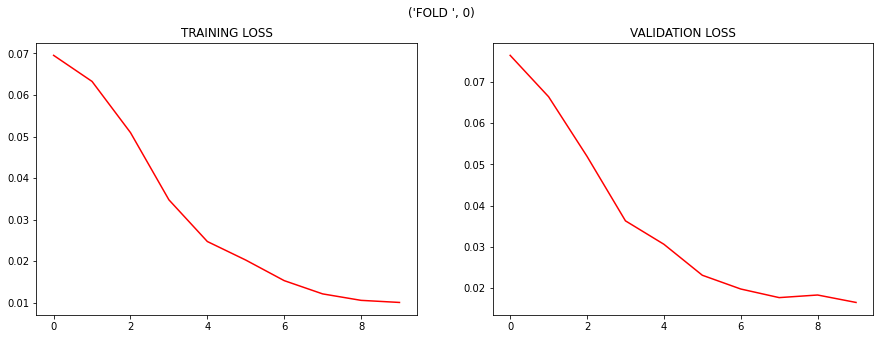

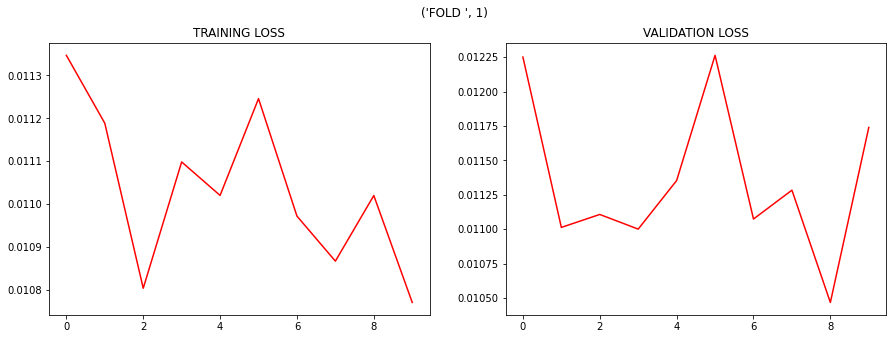

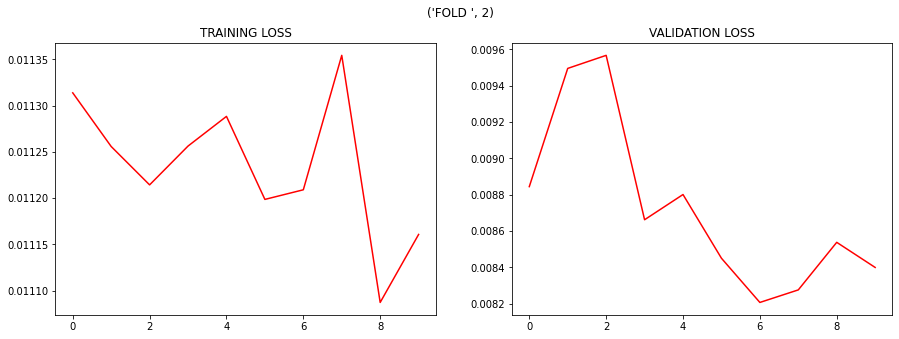

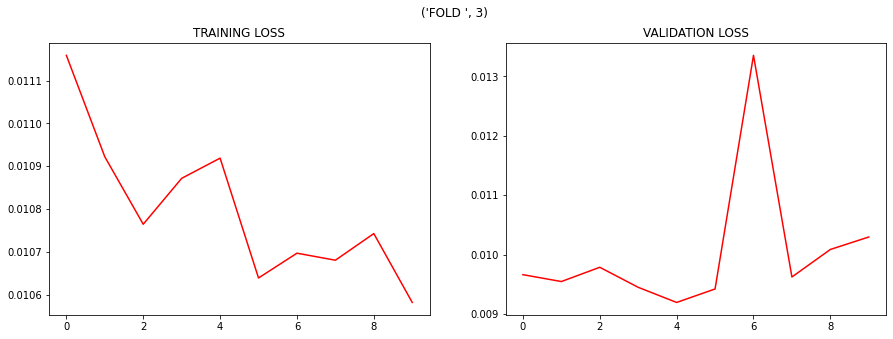

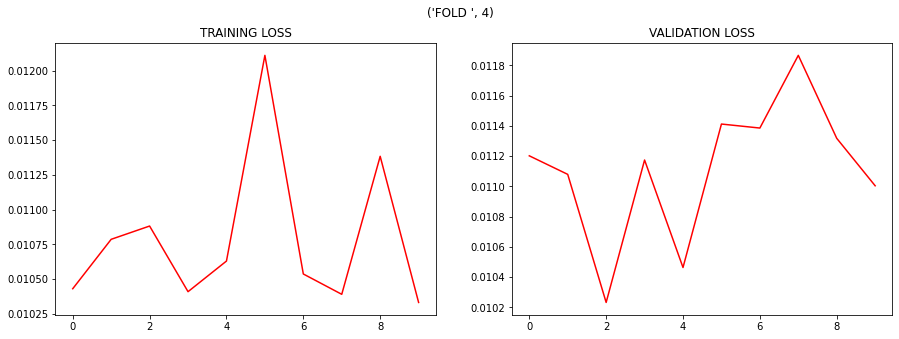

In [ ]:
for i in range(folds):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(num_epochs),train_loss[i],'r')
    plt.title("TRAINING LOSS")
    plt.subplot(122)
    plt.plot(range(num_epochs),valid_loss[i],'r')
    plt.title("VALIDATION LOSS")
    plt.suptitle(('FOLD ',i))

Plotting Accuracy across each Fold

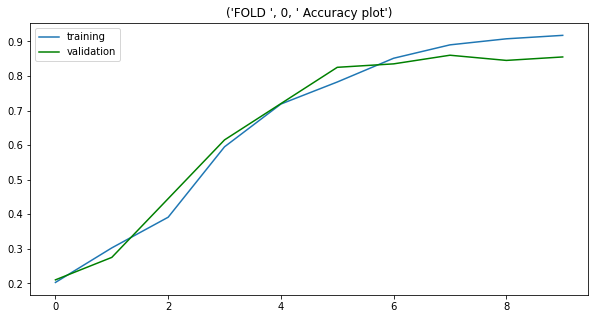

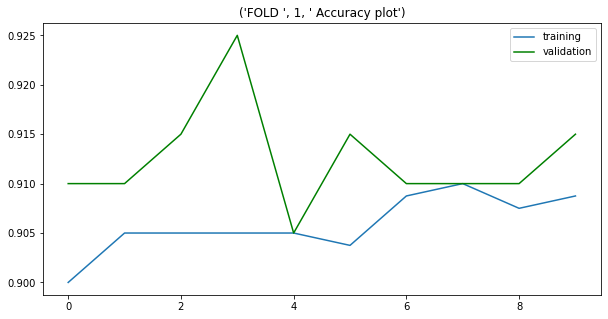

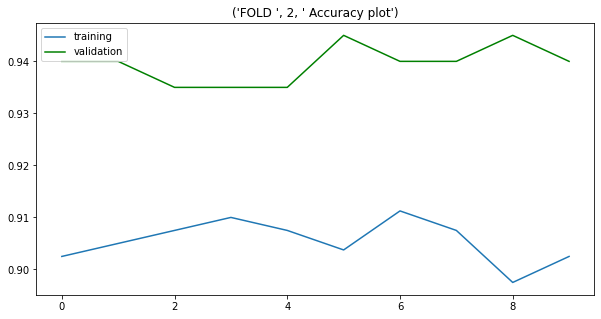

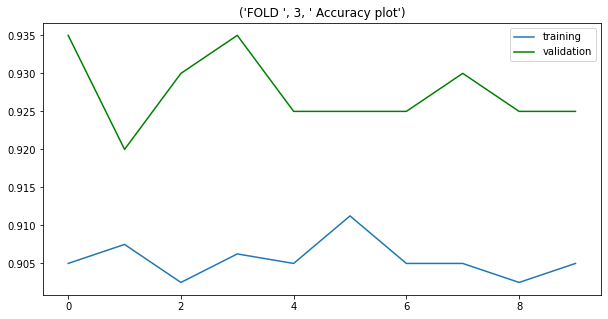

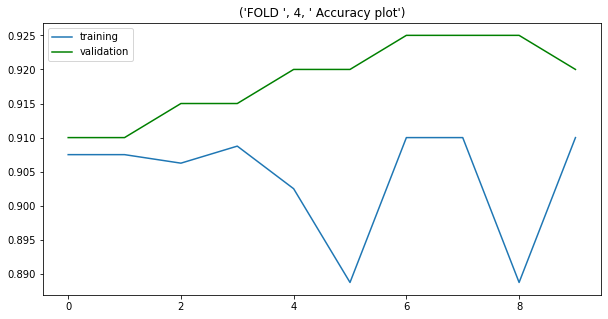

In [ ]:
for i in range(folds):
    plt.figure(figsize =(10,5))

    plt.plot(range(num_epochs),train_acc[i])
    plt.plot(range(num_epochs),valid_acc[i],'g')
    plt.title(('FOLD ',i," Accuracy plot"))
    plt.legend(('training','validation'))

Feeding Test data to our model

In [ ]:
#Predicting labels of our test data

test_pred = torch.LongTensor().cuda()
for i,data in enumerate(testloader):
    inputs,labels = data
    if use_gpu:
        inputs, labels = inputs.cuda(),labels.cuda()
    # Feedforward train data batch through model
    output = net(inputs) 
    # Predicted class is the one with maximum probability
    preds = torch.argmax(output,dim=1)
    test_pred = torch.cat((test_pred, preds), dim=0)

In [ ]:
correct_pred = 0
for i in range(len(test_df[1])):
    if(test_pred[i]==test_df[1][i]):
        correct_pred += 1
print('TESTING ACCURACY =',100*(correct_pred/len(test_df[1])))

TESTING ACCURACY = 87.27735368956743
